In [1]:
%run _common.ipynb
%matplotlib inline

import jax.numpy as jnp
from scipy.special import betainc
from jax.scipy.special import beta
import equinox as eqx
import matplotlib.pyplot as plt

from neuralconstitutive.constitutive import PowerLaw
from neuralconstitutive.tipgeometry import Spherical
from neuralconstitutive.ting import force_approach_scalar, t1_scalar, force_retract_scalar
from neuralconstitutive.smoothing import make_smoothed_cubic_spline
from neuralconstitutive.io import ForceIndentDataSegment

In [2]:
constit = PowerLaw(E0=1.0, alpha = 0.6)
tip = Spherical(R = 1.0)

t_app = jnp.linspace(0.0, 1.0, 1000)
t_ret = jnp.linspace(1.0, 2.0, 1000)
v = 1.0

def force_approach_analytic(t, constit: PowerLaw, v, tip):
    a, b = tip.a(), tip.b()
    coeff = a*b*constit.E0*(v**b)*beta(1-constit.alpha, b)
    return coeff*(t**(b-constit.alpha))

def t1_analytic(t, constit, t_max):
    const = 2**(1/(1-constit.alpha))
    return jnp.clip(t-const*(t-t_max), 0.0)

def force_retract_analytic(t, constit: PowerLaw, v, t_max, tip):
    a, b = tip.a(), tip.b()
    coeff = a*b*constit.E0*(v**b)*beta(b, 1-constit.alpha)
    t1 = t1_analytic(t, constit, t_max)
    return coeff*(t**(b-constit.alpha))*betainc(b, 1-constit.alpha, t1/t)

f_app = force_approach_analytic(t_app, constit, v, tip)
t1 = t1_analytic(t_ret, constit, t_app[-1])
f_ret = force_retract_analytic(t_ret, constit, v, t_app[-1], tip)

In [3]:
app_interp = make_smoothed_cubic_spline(ForceIndentDataSegment(t_app, v*t_app, None))
ret_interp = make_smoothed_cubic_spline(ForceIndentDataSegment(t_ret, v*(2-t_ret), None))

f_app_ting = eqx.filter_vmap(force_approach_scalar, in_axes = (0, None, None, None))(t_app, constit, app_interp, tip)
t1_ting = eqx.filter_vmap(t1_scalar, in_axes = (0, None, None))(t_ret, constit, (app_interp, ret_interp))
f_ret_ting = eqx.filter_vmap(force_retract_scalar, in_axes = (0, None, None, None))(t_ret, constit, (app_interp, ret_interp), tip)

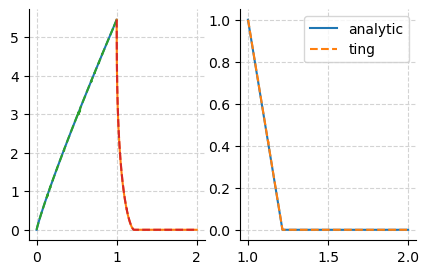

In [4]:
fig, axes = plt.subplots(1, 2, figsize = (5, 3))
axes[0].plot(t_app, f_app, label = "analytic")
axes[0].plot(t_ret, f_ret, label = "analytic")
axes[0].plot(t_app, f_app_ting, "--", label = "ting")
axes[0].plot(t_ret, f_ret_ting, "--", label = "ting")

axes[1].plot(t_ret, t1, label = "analytic")
axes[1].plot(t_ret, t1_ting, "--", label = "ting")
axes[1].legend()